In [1]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, optimizers
import matplotlib.pyplot as plt
import math # 用于计算 ceil，确保 steps_per_epoch 完整

2025-06-12 12:33:33.914515: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-12 12:33:34.714354: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-06-12 12:33:35.021964: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-06-12 12:33:35.105298: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-12 12:33:35.706190: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# --- 1. Path Settings and Hyperparameters Definition ---
# Based on your file structure, your Jupyter Notebook (or this script) is inside the 'classify-leaves' folder.
# The 'images/', 'train.csv', and 'test.csv' are also inside 'classify-leaves'.
# Therefore, the base directory is the current directory '.'
BASE_DIR = './'
TRAIN_CSV_PATH = os.path.join(BASE_DIR, 'train.csv')
TEST_CSV_PATH = os.path.join(BASE_DIR, 'test.csv')

In [3]:
# Uniform image dimensions (must match model input dimensions)
IMAGE_WIDTH, IMAGE_HEIGHT = 150, 150
IMAGE_SIZE = (IMAGE_WIDTH, IMAGE_HEIGHT)
CHANNELS = 3 # RGB color images

In [4]:
# Training hyperparameters
BATCH_SIZE = 32
EPOCHS = 30 # Can be adjusted as needed, start with a reasonable number
LEARNING_RATE = 0.001 # Learning rate, default for Adam optimizer

print("--- Path and Hyperparameters Setup Complete ---")
print(f"Data Directory: {BASE_DIR}")
print(f"Train CSV Path: {TRAIN_CSV_PATH}")
print(f"Test CSV Path: {TEST_CSV_PATH}")
print(f"Image Size: {IMAGE_SIZE}, Channels: {CHANNELS}")
print(f"Batch Size: {BATCH_SIZE}, Epochs: {EPOCHS}, Learning Rate: {LEARNING_RATE}")

--- Path and Hyperparameters Setup Complete ---
Data Directory: ./
Train CSV Path: ./train.csv
Test CSV Path: ./test.csv
Image Size: (150, 150), Channels: 3
Batch Size: 32, Epochs: 30, Learning Rate: 0.001


In [5]:
# --- 2. Load Training and Test Data CSV Files ---
print("\n--- Loading CSV Files ---")
try:
    train_df = pd.read_csv(TRAIN_CSV_PATH)
    test_df = pd.read_csv(TEST_CSV_PATH)
    print(f"Successfully loaded training set, number of samples: {len(train_df)}")
    print(f"Successfully loaded test set, number of samples: {len(test_df)}")
    # Print a preview of the training set to confirm 'image' and 'label' columns are correct
    print("\nTraining Data Preview:")
    print(train_df.head())
    print("\nTest Data Preview:")
    print(test_df.head())
except FileNotFoundError as e:
    print(f"Error: CSV file not found. Please check the path. Error message: {e}")
    print(f"Expected train.csv path: {os.path.abspath(TRAIN_CSV_PATH)}")
    print(f"Expected test.csv path: {os.path.abspath(TEST_CSV_PATH)}")
    exit() # Exit if file not found


--- Loading CSV Files ---
Successfully loaded training set, number of samples: 18353
Successfully loaded test set, number of samples: 8800

Training Data Preview:
          image             label
0  images/0.jpg  maclura_pomifera
1  images/1.jpg  maclura_pomifera
2  images/2.jpg  maclura_pomifera
3  images/3.jpg  maclura_pomifera
4  images/4.jpg  maclura_pomifera

Test Data Preview:
              image
0  images/18353.jpg
1  images/18354.jpg
2  images/18355.jpg
3  images/18356.jpg
4  images/18357.jpg


In [6]:
# --- 3. Image Preprocessing and Data Augmentation (using ImageDataGenerator) ---
print("\n--- Setting up ImageDataGenerators for data preprocessing and augmentation ---")
# --- 新增代码：为图片路径创建绝对路径 ---
# 确保在 ImageDataGenerator.flow_from_dataframe 之前完成
current_working_directory = os.getcwd() # 获取当前脚本的实际工作目录
print(f"\n当前工作目录 (CWD): {current_working_directory}")

# 如果 BASE_DIR 是 './'，那么 os.path.join(current_working_directory, BASE_DIR) 实际上就是 CWD
# 因此，图片的绝对路径应该是 os.path.join(current_working_directory, image_path_from_csv)
train_df['image_full_path'] = train_df['image'].apply(lambda x: os.path.join(current_working_directory, x))
test_df['image_full_path'] = test_df['image'].apply(lambda x: os.path.join(current_working_directory, x))

print("\n图片完整路径预览 (train_df):")
print(train_df[['image', 'image_full_path']].head())

# Training data generator configuration: includes data augmentation and normalization
train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scale pixel values to 0-1 range
    validation_split=0.2,           # Split 20% from training set for validation
    rotation_range=30,              # Random rotation angle (0-30 degrees)
    width_shift_range=0.2,          # Random horizontal shift (20% of total width)
    height_shift_range=0.2,         # Random vertical shift (20% of total height)
    shear_range=0.2,                # Shear intensity
    zoom_range=0.2,                 # Random zoom range
    horizontal_flip=True,           # Random horizontal flip
    fill_mode='nearest'             # Method for filling newly created pixels
)


--- Setting up ImageDataGenerators for data preprocessing and augmentation ---

当前工作目录 (CWD): /workspace/b24011208_聂依萍_树叶分类/classify-leaves

图片完整路径预览 (train_df):
          image                                    image_full_path
0  images/0.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
1  images/1.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
2  images/2.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
3  images/3.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...
4  images/4.jpg  /workspace/b24011208_聂依萍_树叶分类/classify-leaves/...


In [7]:
# Test/Validation data generator configuration: only normalization (no augmentation, preserves original data features)
# Note: Can reuse train_datagen's rescale, but defined separately for clarity
test_datagen = ImageDataGenerator(rescale=1./255)

# Create training set generator
# directory: Root directory of image files. Since the 'image' column in CSV is 'images/0.jpg',
# and the 'images' folder is inside 'BASE_DIR', this is set to BASE_DIR (i.e., '.')
train_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_DIR,               # Image root directory
    x_col='image',                    # Column name in DataFrame containing image paths
    y_col='label',                    # Column name in DataFrame containing labels
    target_size=IMAGE_SIZE,           # Dimensions images will be resized to
    batch_size=BATCH_SIZE,            # Number of images per batch
    class_mode='categorical',         # Label mode: for multi-class classification, outputs one-hot encoded labels
    subset='training',                # Specify as training subset
    shuffle=True,                     # Shuffle data during training
    color_mode='rgb'                  # Ensure RGB color mode, matches model input
)

Found 13488 validated image filenames belonging to 176 classes.


/root/miniforge3/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1493 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [8]:
# Create validation set generator
validation_gen = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=BASE_DIR,
    x_col='image',
    y_col='label',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',              # Specify as validation subset
    shuffle=False,                    # Validation set typically not shuffled for consistency
    color_mode='rgb'
)

Found 3372 validated image filenames belonging to 176 classes.


/root/miniforge3/lib/python3.10/site-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1493 invalid image filename(s) in x_col="image". These filename(s) will be ignored.
  warnings.warn(


In [9]:
# Create test set generator (for prediction, no labels)
test_gen = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=BASE_DIR,
    x_col='image',
    y_col=None,                       # Test set has no labels
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode=None,                  # No labels needed
    shuffle=False,                    # Do not shuffle data during prediction
    color_mode='rgb'
)

print("\n--- ImageDataGenerators Created Successfully ---")
# Print the number of images and classes found by the generators, crucial for checking data loading
print(f"Training Generator: Found {train_gen.samples} images belonging to {len(train_gen.class_indices)} classes.")
print(f"Validation Generator: Found {validation_gen.samples} images belonging to {len(validation_gen.class_indices)} classes.")
print(f"Test Generator: Found {test_gen.samples} images.")

Found 8800 validated image filenames.

--- ImageDataGenerators Created Successfully ---
Training Generator: Found 13488 images belonging to 176 classes.
Validation Generator: Found 3372 images belonging to 176 classes.
Test Generator: Found 8800 images.


In [10]:
# Check if images and classes were found successfully
if train_gen.samples == 0 or len(train_gen.class_indices) == 0:
    print("Error: Training set generator found no images or classes. Please check BASE_DIR and image paths in CSV.")
    exit()

# Get the number of classes (from the training set generator, this is the most reliable way)
num_classes = len(train_gen.class_indices) # Changed to len(train_gen.class_indices)
print(f"Number of classes for model output layer: {num_classes}")

Number of classes for model output layer: 176


In [11]:
# Get the mapping from class names to indices (for later mapping prediction results)
# train_gen.class_indices is a dictionary, e.g., {'class_name_A': 0, 'class_name_B': 1, ...}
# We need a mapping from index to class name for prediction results
idx_to_label = dict((v,k) for k,v in train_gen.class_indices.items())

In [12]:
# --- 4. Build Convolutional Neural Network (CNN) Model ---
print("\n--- Building CNN Model ---")
model = models.Sequential([
    # First set of convolutional and pooling layers
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, CHANNELS)),
    layers.MaxPooling2D(2, 2),

    # Second set of convolutional and pooling layers
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Third set of convolutional and pooling layers
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Fourth set of convolutional and pooling layers (optional, can increase model depth)
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D(2, 2),

    # Flatten layer, converts 2D feature maps to 1D vector
    layers.Flatten(),

    # Fully connected layer (Dense layer)
    layers.Dense(512, activation='relu'), # More neurons can learn more complex features
    layers.Dropout(0.5), # Dropout layer, prevents overfitting by randomly dropping 50% of neurons

    # Output layer: number of neurons equals the number of classes, uses softmax activation for multi-class classification
    layers.Dense(num_classes, activation='softmax')
])


--- Building CNN Model ---


/root/miniforge3/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
I0000 00:00:1749731623.371707    1898 cuda_executor.cc:1015] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-06-12 12:33:44.205145: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2343] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your p

In [13]:
# Compile the model: define optimizer, loss function, and evaluation metrics
model.compile(optimizer=optimizers.Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy', # Suitable for one-hot encoded classification problems
              metrics=['accuracy'])

print("\nCNN Model Summary:")
model.summary()


CNN Model Summary:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 15, 15, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 176)            │        90,288 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,901,744 (26.33 MB)

 Trainable params: 6,901,744 (26.33 MB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# --- 调试：手动加载图片以检查损坏 ---
print("\n--- 正在手动测试图片加载，请注意潜在的错误 ---")
num_test_images = 10 # 尝试加载前10张图片
for i in range(min(num_test_images, len(train_df))):
    image_relative_path = train_df.iloc[i]['image']
    image_full_path = os.path.join(BASE_DIR, image_relative_path)
    try:
        # 使用 Pillow 直接加载图片
        from PIL import Image
        with Image.open(image_full_path) as img:
            img.verify() # 验证图片完整性，但不会完全加载
            print(f"图片 {image_relative_path} 加载成功 (PIL.Image.open)。")
    except Exception as e:
        print(f"错误: 图片 {image_relative_path} 加载失败或损坏。错误信息: {e}")
        print(f"请检查此文件: {image_full_path}")
        # 遇到损坏图片后停止，您可以继续迭代或退出
        # break # 如果想在发现第一个损坏图片后停止
print("--- 图片加载测试完成 ---")


--- 正在手动测试图片加载，请注意潜在的错误 ---
图片 images/0.jpg 加载成功 (PIL.Image.open)。
图片 images/1.jpg 加载成功 (PIL.Image.open)。
图片 images/2.jpg 加载成功 (PIL.Image.open)。
图片 images/3.jpg 加载成功 (PIL.Image.open)。
图片 images/4.jpg 加载成功 (PIL.Image.open)。
图片 images/5.jpg 加载成功 (PIL.Image.open)。
图片 images/6.jpg 加载成功 (PIL.Image.open)。
图片 images/7.jpg 加载成功 (PIL.Image.open)。
图片 images/8.jpg 加载成功 (PIL.Image.open)。
图片 images/9.jpg 加载成功 (PIL.Image.open)。
--- 图片加载测试完成 ---


In [15]:
# --- 5. Train the Model ---
print("\n--- Starting Model Training ---")

# Calculate steps per epoch for training and validation
# math.ceil ensures that even incomplete last batches are processed
steps_per_epoch = math.ceil(train_gen.samples / BATCH_SIZE)
validation_steps = math.ceil(validation_gen.samples / BATCH_SIZE)

print(f"Training steps per Epoch: {steps_per_epoch}")
print(f"Validation steps per Epoch: {validation_steps}")

try:   
    history = model.fit(
        train_gen,                        # Training data generator
        steps_per_epoch=steps_per_epoch,  # Number of training steps per epoch
        epochs=EPOCHS,                    # Total number of training epochs
        validation_data=validation_gen,   # Validation data generator
        validation_steps=validation_steps # Number of validation steps per epoch
    )
    print("\nModel training completed.")
except Exception as e:
    print(f"Error during model training: {e}")
    print("Please check if your resources (RAM/GPU VRAM) are sufficient, or try reducing BATCH_SIZE.")
    exit()


--- Starting Model Training ---
Training steps per Epoch: 422
Validation steps per Epoch: 106


/root/miniforge3/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 127s 296ms/step - accuracy: 0.0123 - loss: 5.1083 - val_accuracy: 0.0507 - val_loss: 4.4931
Epoch 2/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 124s 294ms/step - accuracy: 0.0359 - loss: 4.4884 - val_accuracy: 0.0970 - val_loss: 3.9536
Epoch 3/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 124s 293ms/step - accuracy: 0.0712 - loss: 4.0450 - val_accuracy: 0.1483 - val_loss: 3.5708
Epoch 4/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 125s 296ms/step - accuracy: 0.0954 - loss: 3.7381 - val_accuracy: 0.1693 - val_loss: 3.2936
Epoch 5/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 125s 296ms/step - accuracy: 0.1300 - loss: 3.5033 - val_accuracy: 0.2132 - val_loss: 3.0862
Epoch 6/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 125s 296ms/step - accuracy: 0.1736 - loss: 3.2427 - val_accuracy: 0.2737 - val_loss: 2.7902
Epoch 7/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 124s 295ms/step - accuracy: 0.2063 - loss: 3.0400 - val_accuracy: 0.2954 - val_loss: 2.6729
Epoch 8/30
422/422 ━━━━━━━━━━━━━━━━━━━━ 125s 296ms/step - accuracy: 0.2416 -


--- Visualizing Training Progress ---


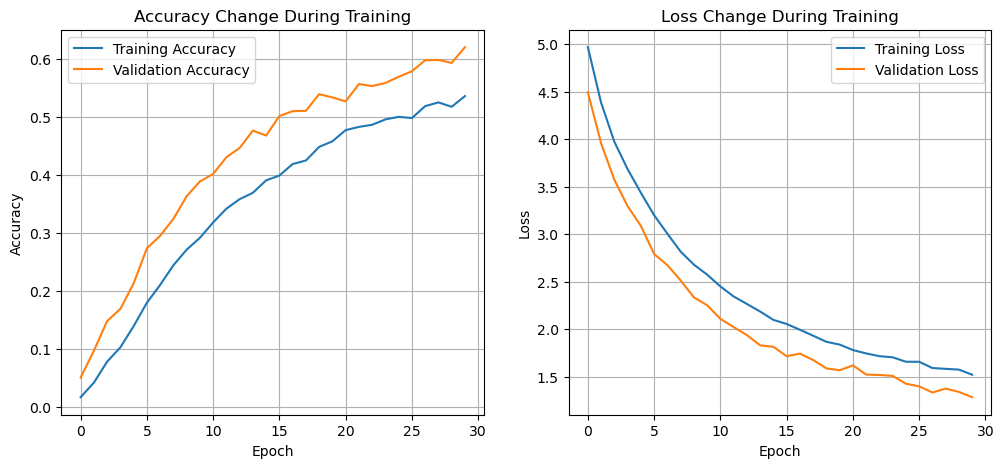

In [16]:
# --- 6. Visualize Training Progress (Optional, but recommended) ---
print("\n--- Visualizing Training Progress ---")
# Plot accuracy curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
if 'val_accuracy' in history.history: # Ensure validation accuracy exists
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Change During Training')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Plot loss curve
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
if 'val_loss' in history.history: # Ensure validation loss exists
    plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Change During Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [17]:
# --- 7. Model Evaluation and Prediction ---
print("\n--- Performing Predictions on Test Set ---")

# Calculate test steps
test_steps = math.ceil(test_gen.samples / BATCH_SIZE)

try:

    # Perform prediction
    predictions = model.predict(test_gen, steps=test_steps, verbose=1) 
    # 使用训练好的模型对测试数据生成器中的图像进行预测，确保覆盖所有测似样本
    #获取每个样本的预测类别索引（概率最高的那个）
    predicted_class_indices = np.argmax(predictions, axis=1)

    # 将预测的索引映射回原始类别名称
    predicted_labels = [idx_to_label[idx] for idx in predicted_class_indices]

    print("\nPrediction completed.")

except Exception as e:
    print(f"Error during prediction: {e}")
    exit()


--- Performing Predictions on Test Set ---
275/275 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step

Prediction completed.


In [18]:
# --- 8. Generate Kaggle Submission File ---
print("\n--- Generating Kaggle Submission File ---")
# 创建一个DataFrame，包含图像文件名和预测标签
submission_df = pd.DataFrame({'image': test_df['image'], 'label': predicted_labels})
# 定义提交文件的保存路径
submission_csv_path = os.path.join(BASE_DIR, 'submission.csv') # 保存到项目根目录
# 将DataFrame保存为CSV文件，不包含索引
submission_df.to_csv(submission_csv_path, index=False)

print(f"Submission file saved to: {submission_csv_path}")
print("All steps completed! Good luck in the competition!")


--- Generating Kaggle Submission File ---
Submission file saved to: ./submission.csv
All steps completed! Good luck in the competition!


#### 代码解释:

##### pd.DataFrame({'image': test_df['image'], 'label': predicted_labels}): 创建一个新的Pandas DataFrame，包含测试集图像的文件名和对应的预测标签。
##### submission_csv_path = os.path.join(BASE_DIR, 'submission.csv'): 定义提交文件的保存路径，通常是项目根目录下的submission.csv。
##### submission_df.to_csv(submission_csv_path, index=False): 将DataFrame保存为CSV文件。index=False表示不写入DataFrame的索引列。